<img align="left" width="250" height="70" src="https://gsb.skku.edu/_res/en/img/common/logo_eng.png"> <br><br><br>

# **Final Exam Part II - Take-Home Data Challenge (10 marks)**

**Programming for Analytics**

**Background**

The marketing team of an e-commerce site has launched an email campaign.

You are in charge of figuring out how the email campaign performed, your analysis should center around the [click through rate](https://en.wikipedia.org/wiki/Click-through_rate).

**Grading Policy**

* Good workflow and clean code (data inspection, data cleaning, comments, Markdown use) (3 marks)
* Accurate understanding and calculation of the click through rate (2 marks)
* Generate Insights and show business impact of your analyses. (5 marks)

**Due Date**

* Due Date: Oct 9 (Mon), 11:59 PM (**No Late Submission Option**)
* <font color="red">You would receive 0 mark if you miss the due date</font>.

---

**Upload to Drive**

<font color="red">Please add a text cell below with your name.
</font>  

# **Email Marketing Performance Evaluation**



## **Goal**


One of the most common data science tasks is optimizing marketing campaigns. Email marketing is one of the most effective marketing tools available.

Emails are great because they are free, scalable, and easily personalized. Personalizing the text and/or the subject, who should receive it, when it should be sent, and so on are all part of email optimization.


## **Challenge Description**

An e-commerce site's marketing team has launched an email campaign. This site contains email addresses from all previous users who created accounts.

They sent emails to **a random sample of** users. The email informs the user of a new feature that has been added to the site. From the marketing team's perspective, **success is defined as the user clicking on the link inside of the email**. This link will take the user to the company's website.

You are in charge of determining the success of the email campaign and have been asked the following questions:

* How many users opened the email, and how many clicked on the link within the email? What are the percentages?

* The VP of marketing believes that sending emails to a random sample of users is stupid. Can you recommend ways to optimize this? In particular, to **maximize the probability** of users clicking on the link inside the email based on all the information you have about the emails sent.

* How much do you believe your proposed method will improve <font color="red">**click through rate (defined as the number of users who click on the link divided by the total number of users who receive the email)</font>**? Explain.

* Did you notice any unusual or interesting patterns in how the email campaign performed for different user segments? Explain.



## **Data**


We have 3 tables in the **"[Email Marketing Campaign Datasets](https://drive.google.com/drive/folders/1Ar8Y_jRhJXMqVOcLAIMPJF8hRrWbeuyy?usp=drive_link)"** folder under the "[**Datasets**](https://drive.google.com/drive/folders/1scYcPnQd0LgyY1VmlvbA7vAPbKFBInob?usp=drive_link)" folder in the shared drive .

The 3 tables are:

1.**email_table** - info about each email that was sent. Columns are:

* **email_id** : unique id of the email that was sent.
* **email_text** : there are two versions of the email: one has “long text” (i.e. has 4 paragraphs) and one has “short text” (just two paragraphs)
* **email_version** : some emails were “personalized” (i.e. they had the name of the user receiving the email in the incipit, such as “Hi John”), while some emails were “generic” (the incipit was just “Hi,”).
* **hour** : hour of the day based on the local time when the email was sent.
* **weekday** : the day on which the email was sent.
* **user_country** : the country where the user receiving the email was based. It comes from the user ip address when she created the account.
* **user_past_purchases** : how many items in the past were bought by the user receiving the email

2.**email_opened_table** - the id of the emails that were opened at least once. Columns are:

* **email_id** : the id of the emails that were opened, i.e. the user clicked on the email and, supposedly, read it.


3.**link_clicked_table** - the id of the emails whose link inside was clicked at least once. Columns are:

* **email_id** : if the user clicked on the link within the email, then the id of the email shows up on this table.


# Solution Starts Here

## 1.Preparation

In [35]:
#package import
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
#load data
email_path = "/content/drive/MyDrive/email_table.csv"
opened_path = "/content/drive/MyDrive/email_opened_table.csv"
link_click_path = "/content/drive/MyDrive/link_clicked_table.csv"

emdf = pd.read_csv(email_path)
opendf = pd.read_csv(opened_path)
clickdf = pd.read_csv(link_click_path)

In [38]:
# simple investigation - non-null count
print(emdf.info()) #  0 null
print(opendf.info())
print(clickdf.info())

#Result: checked the lows and non-null value matches, this means there's no null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    No

In [39]:
# check any duplicated
check1 = opendf.duplicated().sum()
check2 = clickdf.duplicated().sum()
check3 = emdf.duplicated().sum()

print (check1,'\n===\n',check2,'\n===\n',check3)
#Result: checked there are no duplicated.

0 
===
 0 
===
 0


## 2.Merge Tables

* Before merge, I'm going to add one more column on 'opendf' and 'clickdf'. Because those two tables only have one column, to express that opened or click linked value after merge tables.

In [40]:
# Add marking columns
opendf['opened'] = True
clickdf['clicked'] = True

In [56]:
# Merge table
em_open = emdf.merge(opendf, how='left', validate='m:m' )
Basedf = em_open.merge(clickdf, how='left', validate='m:m' )
Basedf

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,True,True
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN
...,...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,NaN,NaN
99996,899722,long_email,personalized,7,Saturday,US,1,NaN,NaN
99997,449610,long_email,personalized,11,Saturday,UK,6,NaN,NaN
99998,72497,short_email,generic,10,Monday,UK,0,NaN,NaN


In [42]:
# check the values are correctly applied
Basedf[Basedf['opened'].isnull()].count() # the count of email id should be 89655.
#Result : Correctly applied.
# But! there are 50 click without email open??.

email_id               89655
email_text             89655
email_version          89655
hour                   89655
weekday                89655
user_country           89655
user_past_purchases    89655
opened                     0
clicked                   50
dtype: int64

In [43]:
#clicked list without email open
#check = Basedf[(Basedf['clicked']==True)&(Basedf['opened'].isnull())]
#check

##3.Analysis email Open Rate & CTR by segment
* Total Openrate and CTR
* Performance by
    * Email text length
    * Email version
    * Hour
    * Week of day
    * User country
    * Past purchases

In [44]:
#check overall open rate and CTR
Total_CTR = Basedf[['email_id','opened','clicked']].count()
Total_CTR['open_rate'] = Total_CTR['opened'] / Total_CTR['email_id']
Total_CTR['CTR'] = Total_CTR['clicked'] / Total_CTR['opened']
Total_CTR

average_o_rate = Total_CTR['open_rate'].round(2)
average_ctr = Total_CTR['CTR'].round(2)

#Total CTR is 10%, total click through rate is 20%

In [45]:
print(f"Total email open rate is {average_o_rate} \nTotal click-Through-Rate is {average_ctr}")

Total email open rate is 0.1 
Total click-Through-Rate is 0.2


In [46]:
#Perf. by Email Length
CTR_by_length = Basedf[['email_id','email_text','opened','clicked']].groupby('email_text').count()
CTR_by_length['open_rate'] = CTR_by_length['opened'] / CTR_by_length['email_id']
CTR_by_length['CTR'] = CTR_by_length['clicked'] / CTR_by_length['opened']
CTR_by_length

# Result : both email has almost same CTR, but Short email showed higher open rate.

,email_id,opened,clicked,open_rate,CTR
email_text,,,,,
long_email,50276,4584,932,0.091177,0.203316
short_email,49724,5761,1187,0.115860,0.206041


In [47]:
#Perf. by Email Version
CTR_by_version = Basedf[['email_id','email_version','opened','clicked']].groupby('email_version').count()
CTR_by_version['open_rate'] = CTR_by_version['opened'] / CTR_by_version['email_id']
CTR_by_version['CTR'] = CTR_by_version['clicked'] / CTR_by_version['opened']
CTR_by_version

# Result : Personalized email showed much higher openrate and CTR than generic email

,email_id,opened,clicked,open_rate,CTR
email_version,,,,,
generic,50209,3984,760,0.079348,0.190763
personalized,49791,6361,1359,0.127754,0.213646


      email_id  opened  clicked  open_rate       CTR
hour                                                
1         2703     239       49   0.088420  0.205021
2         3676     323       60   0.087867  0.185759
3         4610     390       90   0.084599  0.230769
4         5622     496       91   0.088225  0.183468
5         6551     538      118   0.082125  0.219331
6         7465     674      128   0.090288  0.189911
7         8204     739      150   0.090078  0.202977
8         8398     743      159   0.088473  0.213997
9         8529    1072      220   0.125689  0.205224
10        8180    1083      231   0.132396  0.213296
11        7483     947      203   0.126554  0.214361
12        6508     810      167   0.124462  0.206173
13        5581     609      111   0.109120  0.182266
14        4580     501       95   0.109389  0.189621
15        3493     368       87   0.105354  0.236413
16        2759     289       64   0.104748  0.221453
17        1893     207       35   0.109350  0.

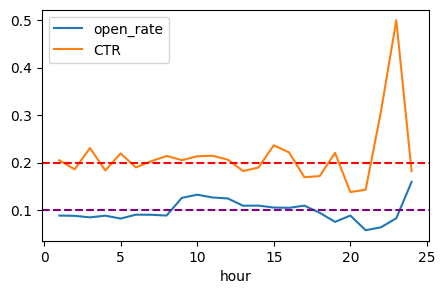

In [48]:
#Perf. by Hours
CTR_by_hour = Basedf[['email_id','hour','opened','clicked']].groupby('hour').count()
CTR_by_hour['open_rate'] = CTR_by_hour['opened'] / CTR_by_hour['email_id']
CTR_by_hour['CTR'] = CTR_by_hour['clicked'] / CTR_by_hour['opened']
print(CTR_by_hour)

#Draw a chart
CTR_by_hour.reset_index().plot.line(x='hour', y=['open_rate','CTR'], figsize=(5,3))
plt.axhline(average_o_rate, color='purple', linestyle='--', label='Average Open Rate')  # 기준선 추가
plt.axhline(average_ctr, color='Red', linestyle='--', label='Average CTR')

# Result : open rate was higher than average from 9 to 12 time slot. and CTR was as average at the same time slot.

           email_id  opened  clicked  open_rate       CTR
weekday                                                  
Monday        14363    1667      329   0.116062  0.197361
Tuesday       14143    1704      352   0.120484  0.206573
Wednesday     14084    1694      389   0.120278  0.229634
Thursday      14277    1691      349   0.118442  0.206387
Friday        14177    1051      199   0.074134  0.189343
Saturday      14569    1277      260   0.087652  0.203602
Sunday        14387    1261      241   0.087649  0.191118


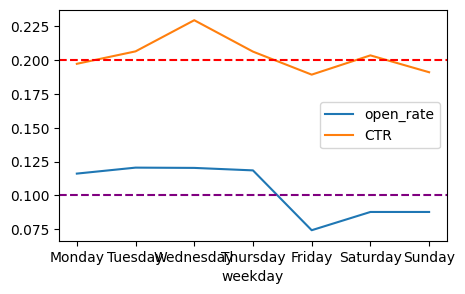

In [49]:
#Perf. by week of day
CTR_by_weekday = Basedf[['email_id','weekday','opened','clicked']].groupby('weekday').count()
CTR_by_weekday['open_rate'] = CTR_by_weekday['opened'] / CTR_by_weekday['email_id']
CTR_by_weekday['CTR'] = CTR_by_weekday['clicked'] / CTR_by_weekday['opened']

#change the index order by weekday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
CTR_by_weekday2 = CTR_by_weekday.reindex(weekday_order)
print(CTR_by_weekday2)

#Draw a chart
weekday_chart = CTR_by_weekday2.reset_index()
weekday_chart.plot.line(x='weekday', y=['open_rate','CTR'], figsize=(5,3))
plt.axhline(average_o_rate, color='purple', linestyle='--', label='Average Open Rate')  # 기준선 추가
plt.axhline(average_ctr, color='Red', linestyle='--', label='Average CTR')
# Result :
# Open rates are high from Monday to Thursday, CTRs are high from Tuesday to Thursday.
# Both open rate and ctr droped significantly on Friday

              email_id  opened  clicked  open_rate       CTR
user_country                                                
ES                9967     390       83   0.039129  0.212821
FR                9995     406       80   0.040620  0.197044
UK               19939    2396      492   0.120167  0.205342
US               60099    7153     1464   0.119020  0.204669


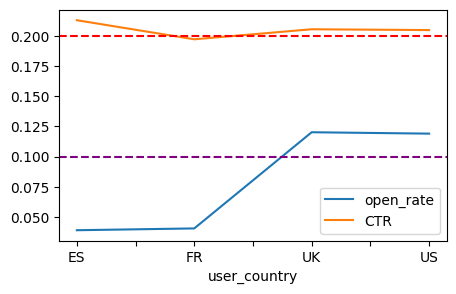

In [50]:
#Perf. by User's country
CTR_by_country = Basedf[['email_id','user_country','opened','clicked']].groupby('user_country').count()
CTR_by_country['open_rate'] = CTR_by_country['opened'] / CTR_by_country['email_id']
CTR_by_country['CTR'] = CTR_by_country['clicked'] / CTR_by_country['opened']
print(CTR_by_country)

#Draw a chart
CTR_by_country2 = CTR_by_country.reset_index()
CTR_by_country2.plot.line(x='user_country', y=['open_rate','CTR'], figsize=(5,3))
plt.axhline(average_o_rate, color='purple', linestyle='--', label='Average Open Rate')  # 기준선 추가
plt.axhline(average_ctr, color='Red', linestyle='--', label='Average CTR')
# Result : Open Rate was significantly high in US and UK while CTR was almost similar in 4 countries

                     email_id  opened  clicked  open_rate       CTR
user_past_purchases                                                
0                       13877     532        7   0.038337  0.013158
1                       13751    1276      154   0.092793  0.120690
2                       13036    1320      200   0.101258  0.151515
3                       12077    1305      200   0.108057  0.153257
4                       10743    1195      230   0.111235  0.192469
5                        9042    1052      201   0.116346  0.191065
6                        7518     928      241   0.123437  0.259698
7                        6051     744      186   0.122955  0.250000
8                        4393     613      174   0.139540  0.283850
9                        3296     444      150   0.134709  0.337838
10                       2363     329      110   0.139230  0.334347
11                       1553     234       87   0.150676  0.371795
12                        944     134       62  

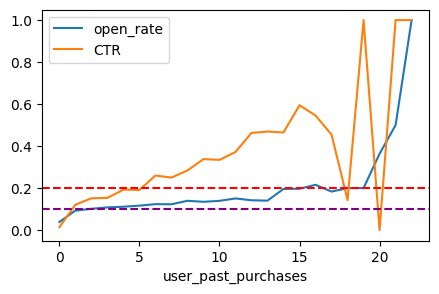

In [51]:
#Perf. by past purchase
CTR_by_pp = Basedf[['email_id','user_past_purchases','opened','clicked']].groupby('user_past_purchases').count()
CTR_by_pp['open_rate'] = CTR_by_pp['opened'] / CTR_by_pp['email_id']
CTR_by_pp['CTR'] = CTR_by_pp['clicked'] / CTR_by_pp['opened']
print(CTR_by_pp)

#Draw a chart
CTR_by_pp2 = CTR_by_pp.reset_index()
CTR_by_pp2.plot.line(x='user_past_purchases', y=['open_rate','CTR'], figsize=(5,3))
plt.axhline(average_o_rate, color='purple', linestyle='--', label='Average Open Rate')  # 기준선 추가
plt.axhline(average_ctr, color='Red', linestyle='--', label='Average CTR')
# Result : More purchases showed higher open rate and higher CTR.
# it seems to be better targeting only the users who purchases more than once or more than 3 times.
# morethan once : the openrate is significantly increase then no purchased user from 3% to 9% (9% is more close to the average open rate 10%)
# more than 4 times : the CTR increases rapidly from 15% to 19% (19% is close to the average CTR 20%)

##  4.Analysis result review & suggestion for Optimization Strategy

## 4-1. Analysis Review :
* Total CTR is 10%, total click through rate(CTR) is 20%.
* Email Length : both email has almost same CTR, but **Short email showed higher open rate**.
* Email Version : **Personalized email showed much higher performance** in both openrate and CTR than generic email.
* Time slot : open rate was higher than average from **9 to 12 time slot**. and CTR was as average at the same time slot.
* Week of Day : **Open rates are high from Monday to Thursday**, CTRs are high from Tuesday to Thursday. Both open rate and ctr droped significantly on Friday and stayed **low during weekend**.
* Country : Open Rate was significantly **high in US and UK** while CTR was almost similar in 4 countries.
* Past Purchases : **More purchases showed higher open rate and higher CTR**.
    * it seems to be better targeting only the users who purchases more than once or more than 4 times.
    * more than once : the openrate is significantly increase than no purchased user from 3% to 9%.
    * more than 4 times : the CTR increases rapidly from 15% to 19%.

* Past Purchases : **More purchases showed higher open rate and higher CTR**.
    * it seems to be better targeting only the users who purchases more than once or more than 4 times.
    * more than once : the openrate is significantly increase than no purchased user from 3% to 9%.
    * more than 4 times : the CTR increases rapidly from 15% to 19%.

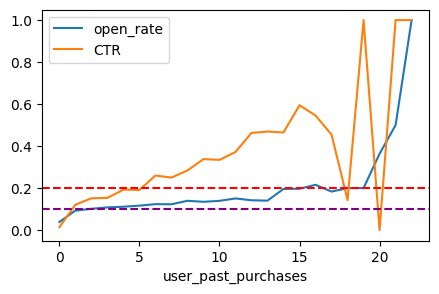

In [52]:
#Draw a chart
CTR_by_pp2 = CTR_by_pp.reset_index()
chart1 = CTR_by_pp2.plot.line(x='user_past_purchases', y=['open_rate','CTR'], figsize=(5,3))
plt.axhline(average_o_rate, color='purple', linestyle='--', label='Average Open Rate')  # 기준선 추가
plt.axhline(average_ctr, color='Red', linestyle='--', label='Average CTR')

In [53]:
# Draw a Heatmap of Weekday and hourly

## 4-2. Recommendation for optimization


1.  Email Length
    * Consider focusing on shorter email content to maintain or increase open Rate, More open rate will deliver more clicks.
2.  Email Version
    * Continue prioritizing personalized emails as they have shown significantly higher performance in both open rates and CTR.
    * Consider more personalization options, such as product recommendations or personalized offers.
3. Time Slot
    * Schedule emails to be sent during the time slots with higher open rates (9 to 12) or late night for higher CTR.
4. Day of the Week Targeting
    * Focus email campaigns on Monday to Thursday for higher open rates.
    * Target Tuesday to Thursday for maximizing CTR.
    * Consider a weekend promotions for increasing CTR.
5. Country Targeting
    * increase prioritizing to US, UK market
    * Consider running country specific campaigns or
6. Targeted Campaigns for High Purchasers
    * Devide user groups by number of purchases. (1) Users who have made morethan one purchase, (2) User who have made more than four purchase, (3) users who have made more than ten times
    * Provide loyalty rewards, exclusive offers or personalized content by the purchase groups
7. Keep testing and Optimization by monitoring Open rate and CTR.
    * Make a dashboard to monitor the key matrics.
    * Continue A/B testing email content.


<ipython-input-73-5dbd502c5c89>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  CTR_by_wdh2=CTR_by_wdh1.pivot('weekday','hour','open_rate')


<Axes: xlabel='hour', ylabel='weekday'>

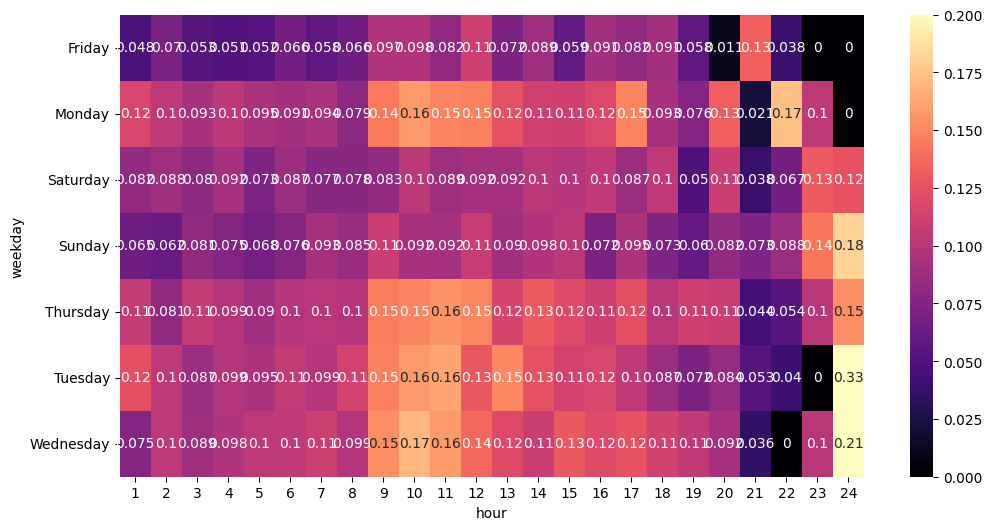

In [73]:
# Week & Day OpenRate & CTR heatmap
CTR_by_wdh = Basedf[['email_id','weekday','hour','opened','clicked']].groupby(['weekday','hour']).count()
CTR_by_wdh['open_rate'] = CTR_by_wdh['opened'] / CTR_by_wdh['email_id']
CTR_by_wdh['CTR'] = CTR_by_wdh['clicked'] / CTR_by_wdh['opened']


#Draw a chart
CTR_by_wdh1 = CTR_by_wdh.reset_index()
CTR_by_wdh2=CTR_by_wdh1.pivot('weekday','hour','open_rate')
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(CTR_by_wdh2, cmap='magma', annot=True, vmax=0.2, )